In [1]:
#!/usr/bin/env python
# # -*- coding: utf-8 -*-
#!/usr/bin/env python
#!pip install tensorflow==1.15

import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os, inspect
import argparse
import time
import seaborn as sns
import re
# import matplotlib
# matplotlib.use("Qt5Agg")
# #matplotlib.use('Agg')
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
import pandas as pd
import sys,inspect
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Postprocess")
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Methods\\Models\\Utils")

import utils  # for utils.py
from utils import *
import global_utils  # for global_utils.py

# import utils
# from utils import *
# import sys
# sys.path.append('../Methods/Models/Utils')
# import global_utils

In [2]:
sysname, tidx = "SST_param", 2
file_path = os.path.abspath("HQRC_analysis.ipynb")
current_directory = os.path.dirname(file_path)
mid_directory = os.path.dirname(current_directory)
parent_directory = os.path.dirname(mid_directory)

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

#current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
results_dir = os.path.join(os.path.dirname(mid_directory), "Results")  # Use os.path.join for path concatenation
print(results_dir)

eval_path = os.path.join(results_dir, sysname, 'Evaluation_Data')
print(eval_path)

model_path = os.path.join(results_dir, sysname, 'Trained_Models')
print(model_path)

fig_path = os.path.join(results_dir, sysname, 'Eval_Figures')
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)  # Use os.makedirs to create parent directories if needed
print(fig_path)

Current Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Data\SST
Parent Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST_param\Evaluation_Data
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST_param\Trained_Models
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST_param\Eval_Figures


In [3]:
models = []
samples = []
nqrc = [20, 10,5]
coupling = [0.5,1.0,2.0,4.0]
tau = [1.0,2.0,4.0,8.0]
nqubits = [4,5,6,7]
for J in coupling:
    for t in tau:
        for n_qrc in nqrc:
            string1 = f"hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_{n_qrc}-A_0.5-J_{J}-fJ_1-V_10-TAU_{t}-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3"
            string2 = f"HQRC-NQRC={n_qrc}-J={J}-tau={t}"
            models.append([os.path.join(eval_path,string1),string2])
            samples.append(string2)
            if J==2.0 and t == 4.0 and n_qrc == 5:
                for n_qubits in nqubits:
                    string1 = f"hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_{n_qrc}-A_0.5-J_{J}-fJ_1-V_10-TAU_{t}-UNIT_{n_qubits}-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3"
                    string2 = f"HQRC-NQRC={n_qrc}-J={J}-tau={t}-nqubits={n_qubits}"
                    models.append([os.path.join(eval_path,string1),string2])
title = "Sea Surface Temperatures"

In [3]:
# models = [[os.path.join(eval_path, "hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_20-IUL_0-REG_1e-07-AU_0-NICS_3"),"HQR-5,V-10,DL=40,IPL=20,n_tests=3"],
#           [os.path.join(eval_path, "hqrc_pinv-RDIM_5-N_used_427-DL_8-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_8-IUL_0-REG_1e-07-AU_0-NICS_1"),"HQR-5,V-10,DL=8,IPL=8,n_tests=1"],
#           [os.path.join(eval_path, "hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.9-J_2.0-fJ_1-V_10-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_1"),"HQR-5,V-10,DL=40,IPL=300,n_tests=1"]]
# samples = ["HQR-5,V-10,DL=40,IPL=20,n_tests=3","HQR-5,V-10,DL=8,IPL=8,n_tests=1","HQR-5,V-10,DL=40,IPL=300,n_tests=1"]
# title = "Sea Surface Temperatures"

In [4]:
rmse_dict = dict()
targets = dict()
outputs = dict()
targets_train = dict()
outputs_train = dict()
sp_outputs = dict()
sp_targets = dict()
Wouts = dict()
coeffs = dict()
rmnse_avg_train_dict = dict()
rmnse_avg_test_dict = dict()
for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'results.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            qs = QResults()
            qs.rmnse_avg_test = rs['rmnse_avg_TEST']
            qs.rmnse_avg_train = rs['rmnse_avg_TRAIN']
            qs.n_pred_005_avg_test = rs['num_accurate_pred_005_avg_TEST']
            qs.n_pred_005_avg_train = rs['num_accurate_pred_005_avg_TRAIN']
            qs.n_pred_050_avg_test = rs['num_accurate_pred_050_avg_TEST']
            qs.n_pred_050_avg_train = rs['num_accurate_pred_050_avg_TRAIN']
            qs.model_name = rs['model_name']
            #if qs.rmnse_avg_test != np.inf and qs.rmnse_avg_train != np.inf:
                #print(rs.keys())
            #print(qs.model_name)
            #print('train={}, test={}'.format(qs.rmnse_avg_train, qs.rmnse_avg_test))
            #qs.info()
            rmnse_avg_train_dict[label] = rs['rmnse_avg_TRAIN']
            rmnse_avg_test_dict[label] = rs['rmnse_avg_TEST']
            pred_test = rs['predictions_all_TEST']
            truth_test = rs['truths_all_TEST']
            pred_train = rs['predictions_all_TRAIN']
            truth_train =rs['truths_all_TRAIN']
            print(pred_test.shape)
            M = len(pred_test)
            print('{} Number of test'.format(qs.model_name), M)
            rmsels = []
            for j in range(M):
                    rmsels.append(calNRMSE(pred_test[j], truth_test[j]))

            rmse_dict[label] = np.mean(np.array(rmsels), axis=0)
            print(rmse_dict[label].shape)


            targets[label] = truth_test[0] #0th test 
            outputs[label] = pred_test[0]

            targets_train[label] = truth_train[0] #0th test 
            outputs_train[label] = pred_train[0]
            # For frequency
            sp_outputs[label] = rs['sp_pred_TEST']
            sp_targets[label] = rs['sp_true_TEST']
    else:
        print('Not found {}'.format(fname))
    # if trained_models is not None:
    #     rfolder, label = trained_models[i][0], trained_models[i][1]
    #     fname = os.path.join(rfolder, 'data.pickle')
    #     if os.path.isfile(fname):
    #         print('File existed: ', fname)
    #         with open(fname, 'rb') as rfile:
    #             #try:
    #             rs = pickle.load(rfile)
    #             #except:
    #             #    continue
    #             print(rs.keys())
    #             coeffs[label] = np.array(rs['coeffs'])
    #             Wouts[label]  = rs['W_out'][:-1].reshape((coeffs[label].shape[0], -1))
    #             print(Wouts[label].shape, coeffs[label].shape)
    #     else:
    #         print('Not found saved model {}'.format(fname))

(3, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_20-A_0.5-J_0.5-fJ_1-V_10-TAU_1.0-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_10-A_0.5-J_0.5-fJ_1-V_10-TAU_1.0-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.5-J_0.5-fJ_1-V_10-TAU_1.0-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_20-A_0.5-J_0.5-fJ_1-V_10-TAU_2.0-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_10-A_0.5-J_0.5-fJ_1-V_10-TAU_2.0-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.5-J_0.5-fJ_1-V_10-TAU_2.0-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3 Number of test 3
(300,)
(3, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_20-A_0.5-J_0.5-fJ_1-V_

In [5]:
#Manually calculated ignore
model_test_error = []
test_avg_error = []
for label in samples:
    model_test_error.append([label,np.mean(rmse_dict[label])])
    test_avg_error.append(np.mean(rmse_dict[label]))
print(model_test_error)
print("Test Average error = ",np.mean(test_avg_error))

[['HQRC-NQRC=20-J=0.5-tau=1.0', 1.893595665974481], ['HQRC-NQRC=10-J=0.5-tau=1.0', 1.6846269170028283], ['HQRC-NQRC=5-J=0.5-tau=1.0', 1.6167052861791165], ['HQRC-NQRC=20-J=0.5-tau=2.0', 1.7423474551095968], ['HQRC-NQRC=10-J=0.5-tau=2.0', 1.554233521355046], ['HQRC-NQRC=5-J=0.5-tau=2.0', 1.0252781082413387], ['HQRC-NQRC=20-J=0.5-tau=4.0', 1.0772562857971784], ['HQRC-NQRC=10-J=0.5-tau=4.0', 1.2802391530774802], ['HQRC-NQRC=5-J=0.5-tau=4.0', 1.0968718453205024], ['HQRC-NQRC=20-J=0.5-tau=8.0', 1.3796092635935575], ['HQRC-NQRC=10-J=0.5-tau=8.0', 1.4021188101500082], ['HQRC-NQRC=5-J=0.5-tau=8.0', 1.0873867956914725], ['HQRC-NQRC=20-J=1.0-tau=1.0', 1.7423474551095968], ['HQRC-NQRC=10-J=1.0-tau=1.0', 1.554233521355046], ['HQRC-NQRC=5-J=1.0-tau=1.0', 1.0252781082413387], ['HQRC-NQRC=20-J=1.0-tau=2.0', 1.0772562857971784], ['HQRC-NQRC=10-J=1.0-tau=2.0', 1.2802391530774802], ['HQRC-NQRC=5-J=1.0-tau=2.0', 1.0968718453205024], ['HQRC-NQRC=20-J=1.0-tau=4.0', 1.3796092635935575], ['HQRC-NQRC=10-J=1.0

In [6]:
print(rmnse_avg_train_dict)
print(rmnse_avg_test_dict)
error_array_test = []
error_array_train = []
for label in samples:
    error_array_train.append(rmnse_avg_train_dict[label])
    error_array_test.append(rmnse_avg_test_dict[label])
print("Train average error for HQRC =", np.mean(error_array_train))
print("Test average error for HQRC =", np.mean(error_array_test))

{'HQRC-NQRC=20-J=0.5-tau=1.0': 1.298788564429395, 'HQRC-NQRC=10-J=0.5-tau=1.0': 0.9544628101203149, 'HQRC-NQRC=5-J=0.5-tau=1.0': 0.900354683715279, 'HQRC-NQRC=20-J=0.5-tau=2.0': 1.3037953676084064, 'HQRC-NQRC=10-J=0.5-tau=2.0': 1.1835341419035112, 'HQRC-NQRC=5-J=0.5-tau=2.0': 0.4439716554158784, 'HQRC-NQRC=20-J=0.5-tau=4.0': 0.7673539909132776, 'HQRC-NQRC=10-J=0.5-tau=4.0': 1.084646126783872, 'HQRC-NQRC=5-J=0.5-tau=4.0': 0.3382336196320806, 'HQRC-NQRC=20-J=0.5-tau=8.0': 0.6845248132455378, 'HQRC-NQRC=10-J=0.5-tau=8.0': 0.3753026588306539, 'HQRC-NQRC=5-J=0.5-tau=8.0': 0.39471574354451133, 'HQRC-NQRC=20-J=1.0-tau=1.0': 1.3037953676084064, 'HQRC-NQRC=10-J=1.0-tau=1.0': 1.1835341419035112, 'HQRC-NQRC=5-J=1.0-tau=1.0': 0.4439716554158784, 'HQRC-NQRC=20-J=1.0-tau=2.0': 0.7673539909132776, 'HQRC-NQRC=10-J=1.0-tau=2.0': 1.084646126783872, 'HQRC-NQRC=5-J=1.0-tau=2.0': 0.3382336196320806, 'HQRC-NQRC=20-J=1.0-tau=4.0': 0.6845248132455378, 'HQRC-NQRC=10-J=1.0-tau=4.0': 0.3753026588306539, 'HQRC-NQ

In [7]:
#Sort the dictionary by its values
sorted_rmnse_train = sorted(rmnse_avg_train_dict.items(), key=lambda item: item[1])

#Extract the top 5 keys with the lowest values
#top_5_models_train = [key for key, value in sorted_rmnse_train[:5]]
top_5_models_train = dict(sorted_rmnse_train[:5])
print("Top 5 models with the lowest RMNSE values for training data:", top_5_models_train)

Top 5 models with the lowest RMNSE values for training data: {'HQRC-NQRC=5-J=1.0-tau=8.0': 0.15731739614024548, 'HQRC-NQRC=5-J=2.0-tau=4.0': 0.15731739614024548, 'HQRC-NQRC=5-J=2.0-tau=4.0-nqubits=6': 0.15731739614024548, 'HQRC-NQRC=5-J=4.0-tau=2.0': 0.15731739614024548, 'HQRC-NQRC=5-J=2.0-tau=8.0': 0.27364656581544344}


In [8]:
# Step 1: Sort the dictionary by its values
sorted_rmnse_test = sorted(rmnse_avg_test_dict.items(), key=lambda item: item[1])

# Step 2: Extract the top 5 keys with the lowest values
#top_5_models_train = [key for key, value in sorted_rmnse_train[:5]]
top_5_models_test = dict(sorted_rmnse_test[:5])
print("Top 5 models with the lowest RMNSE values for test data:", top_5_models_test)

Top 5 models with the lowest RMNSE values for test data: {'HQRC-NQRC=5-J=4.0-tau=8.0': 0.8397004048096048, 'HQRC-NQRC=5-J=0.5-tau=2.0': 0.843308103462435, 'HQRC-NQRC=5-J=1.0-tau=1.0': 0.843308103462435, 'HQRC-NQRC=5-J=2.0-tau=4.0-nqubits=4': 0.8516395427995295, 'HQRC-NQRC=5-J=0.5-tau=4.0': 0.8697954239707866}


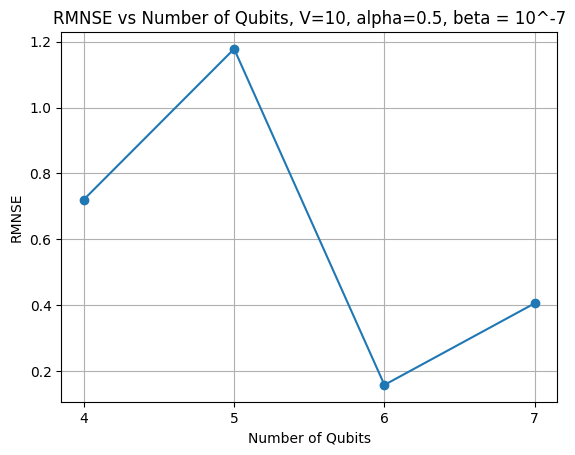

In [30]:
# Extract nqubits and RMSE values
nqubits = []
rmse_values = []
for key, rmse in rmnse_avg_train_dict.items():
    match = re.search(r'nqubits=(\d+)', key)
    if match:
        nqubits.append(int(match.group(1)))
        rmse_values.append(rmse)

# Sort values by nqubits
sorted_indices = sorted(range(len(nqubits)), key=lambda i: nqubits[i])
nqubits = [nqubits[i] for i in sorted_indices]
rmse_values = [rmse_values[i] for i in sorted_indices]

# Plotting
plt.plot(nqubits, rmse_values, marker='o')
plt.xlabel('Number of Qubits')
plt.ylabel('RMNSE')
plt.title('RMNSE vs Number of Qubits, V=10, alpha=0.5, beta = 10^-7')
plt.grid(True)
plt.xticks(nqubits)
plt.show()

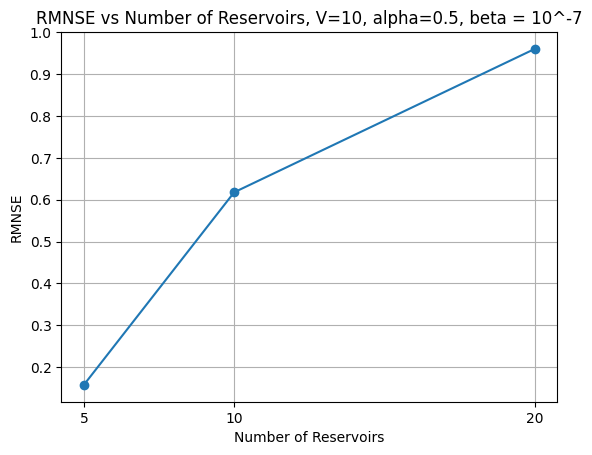

In [31]:
nqrc = []
rmse_values = []
find_keys = []
for n_qrc in [5,10,20]:
    key_string = f"HQRC-NQRC={n_qrc}-J=2.0-tau=4.0"
    find_keys.append(key_string)
for key, rmse in rmnse_avg_train_dict.items():
    if key in find_keys:
        rmse_values.append(rmse)
        start = key.find("NQRC=") + 5
        end = key.find("J")-1
        n_qrc = int(key[start:end])
        nqrc.append(n_qrc)

sorted_indices = sorted(range(len(nqrc)), key=lambda i: nqrc[i])
nqrc = [nqrc[i] for i in sorted_indices]
rmse_values = [rmse_values[i] for i in sorted_indices]

# Plotting
plt.plot(nqrc, rmse_values, marker='o')
plt.xlabel('Number of Reservoirs')
plt.ylabel('RMNSE')
plt.title('RMNSE vs Number of Reservoirs, V=10, alpha=0.5, beta = 10^-7')
plt.grid(True)
plt.xticks(nqrc)
plt.show()

In [44]:
key = f"HQRC-NQRC=5-J=-0.5-tau=-25.1"
start = key.find("tau=") + 4
end = len(key)
n_j = float(key[start:end])
print(n_j)

-25.1


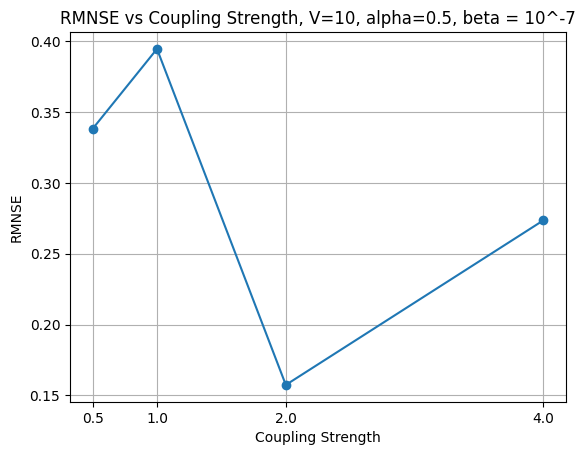

In [39]:
# Extract nqubits and RMSE values
coupling_values = []
rmse_values = []
find_keys = []
for J in [0.5,1.0,2.0,4.0]:
    key_string = f"HQRC-NQRC=5-J={J}-tau=4.0"
    find_keys.append(key_string)
for key, rmse in rmnse_avg_train_dict.items():
    if key in find_keys:
        rmse_values.append(rmse)
        start = key.find("J=") + 2
        end = key.find("tau")-1
        J = float(key[start:end])
        coupling_values.append(J)

# Sort values by nqubits
sorted_indices = sorted(range(len(coupling_values)), key=lambda i: coupling_values[i])
coupling_values = [coupling_values[i] for i in sorted_indices]
rmse_values = [rmse_values[i] for i in sorted_indices]

# Plotting
plt.plot(coupling_values, rmse_values, marker='o')
plt.xlabel('Coupling Strength')
plt.ylabel('RMNSE')
plt.title('RMNSE vs Coupling Strength, V=10, alpha=0.5, beta = 10^-7')
plt.grid(True)
plt.xticks(coupling_values)
plt.show()

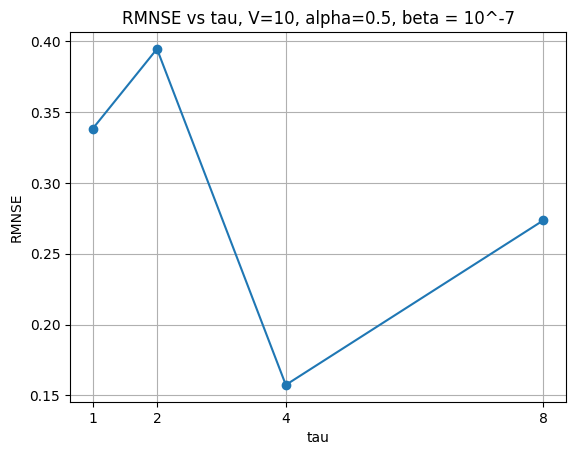

: 

In [46]:
# Extract nqubits and RMSE values
tau_values = []
rmse_values = []
find_keys = []
for t in [1.0,2.0,4.0,8.0]:
    key_string = f"HQRC-NQRC=5-J=2.0-tau={t}"
    find_keys.append(key_string)
for key, rmse in rmnse_avg_train_dict.items():
    if key in find_keys:
        rmse_values.append(rmse)
        start = key.find("tau=") + 4
        end = len(key)
        t = float(key[start:end])
        tau_values.append(t)

# Sort values by nqubits
sorted_indices = sorted(range(len(tau_values)), key=lambda i: tau_values[i])
tau_values = [tau_values[i] for i in sorted_indices]
rmse_values = [rmse_values[i] for i in sorted_indices]

# Plotting
plt.plot(tau_values, rmse_values, marker='o')
plt.xlabel('tau')
plt.ylabel('RMNSE')
plt.title('RMNSE vs tau, V=10, alpha=0.5, beta = 10^-7')
plt.grid(True)
plt.xticks(tau_values)
plt.show()

In [16]:
predictions = []
truths = []
# temp = dict()
# temp[list(top_5_models_train.keys())[0]]=-1
for keys in top_5_models_train:
    predictions.append(outputs_train[keys])
    truths.append(targets_train[keys])
mean_train_predictions = np.mean(predictions, axis=0)
std_train_predictions = np.std(predictions, axis=0)
print("Mean predictions shape:", mean_train_predictions.shape)
print("Standard deviation shape:", std_train_predictions.shape)
print("Mean predictions:\n", mean_train_predictions)
print("Standard deviation:\n", std_train_predictions)
mean_train_truths = np.mean(truths, axis=0)
std_train_truths = np.std(truths, axis=0)
# print("Mean predictions shape:", mean_truths.shape)
# print("Standard deviation shape:", std_truths.shape)
# print("Mean predictions:\n", mean_truths)
# print("Standard deviation:\n", std_truths)

Mean predictions shape: (300, 5)
Standard deviation shape: (300, 5)
Mean predictions:
 [[-382.44154128  -55.3771182    73.4152018     2.64320766   19.44201215]
 [-413.59759289  -46.82420277   88.10439041   -2.12248312   15.93721753]
 [-439.38085127  -37.68655174   95.91585447   -3.68282809    9.5459845 ]
 ...
 [ 397.29660938  -75.25691337  -14.28099449   -1.2040873    -8.1792012 ]
 [ 340.03101145  -83.61311111  -42.78250619   -1.37993803   -7.0398865 ]
 [ 283.6409476   -92.39232977  -64.54903989   -3.44255869   -6.72125285]]
Standard deviation:
 [[3.62706747 0.66875134 2.07827111 1.08448532 2.15394714]
 [5.00555307 0.50931839 2.83369144 1.96285431 2.20655883]
 [5.37353669 0.7864241  3.13102518 2.5550042  1.76055446]
 ...
 [3.42476845 1.23714395 3.39098692 5.46213725 3.21491027]
 [2.50148232 0.68141621 3.15735349 4.99979163 3.87200871]
 [2.34538499 0.33376265 2.53260526 4.34602153 4.38757926]]


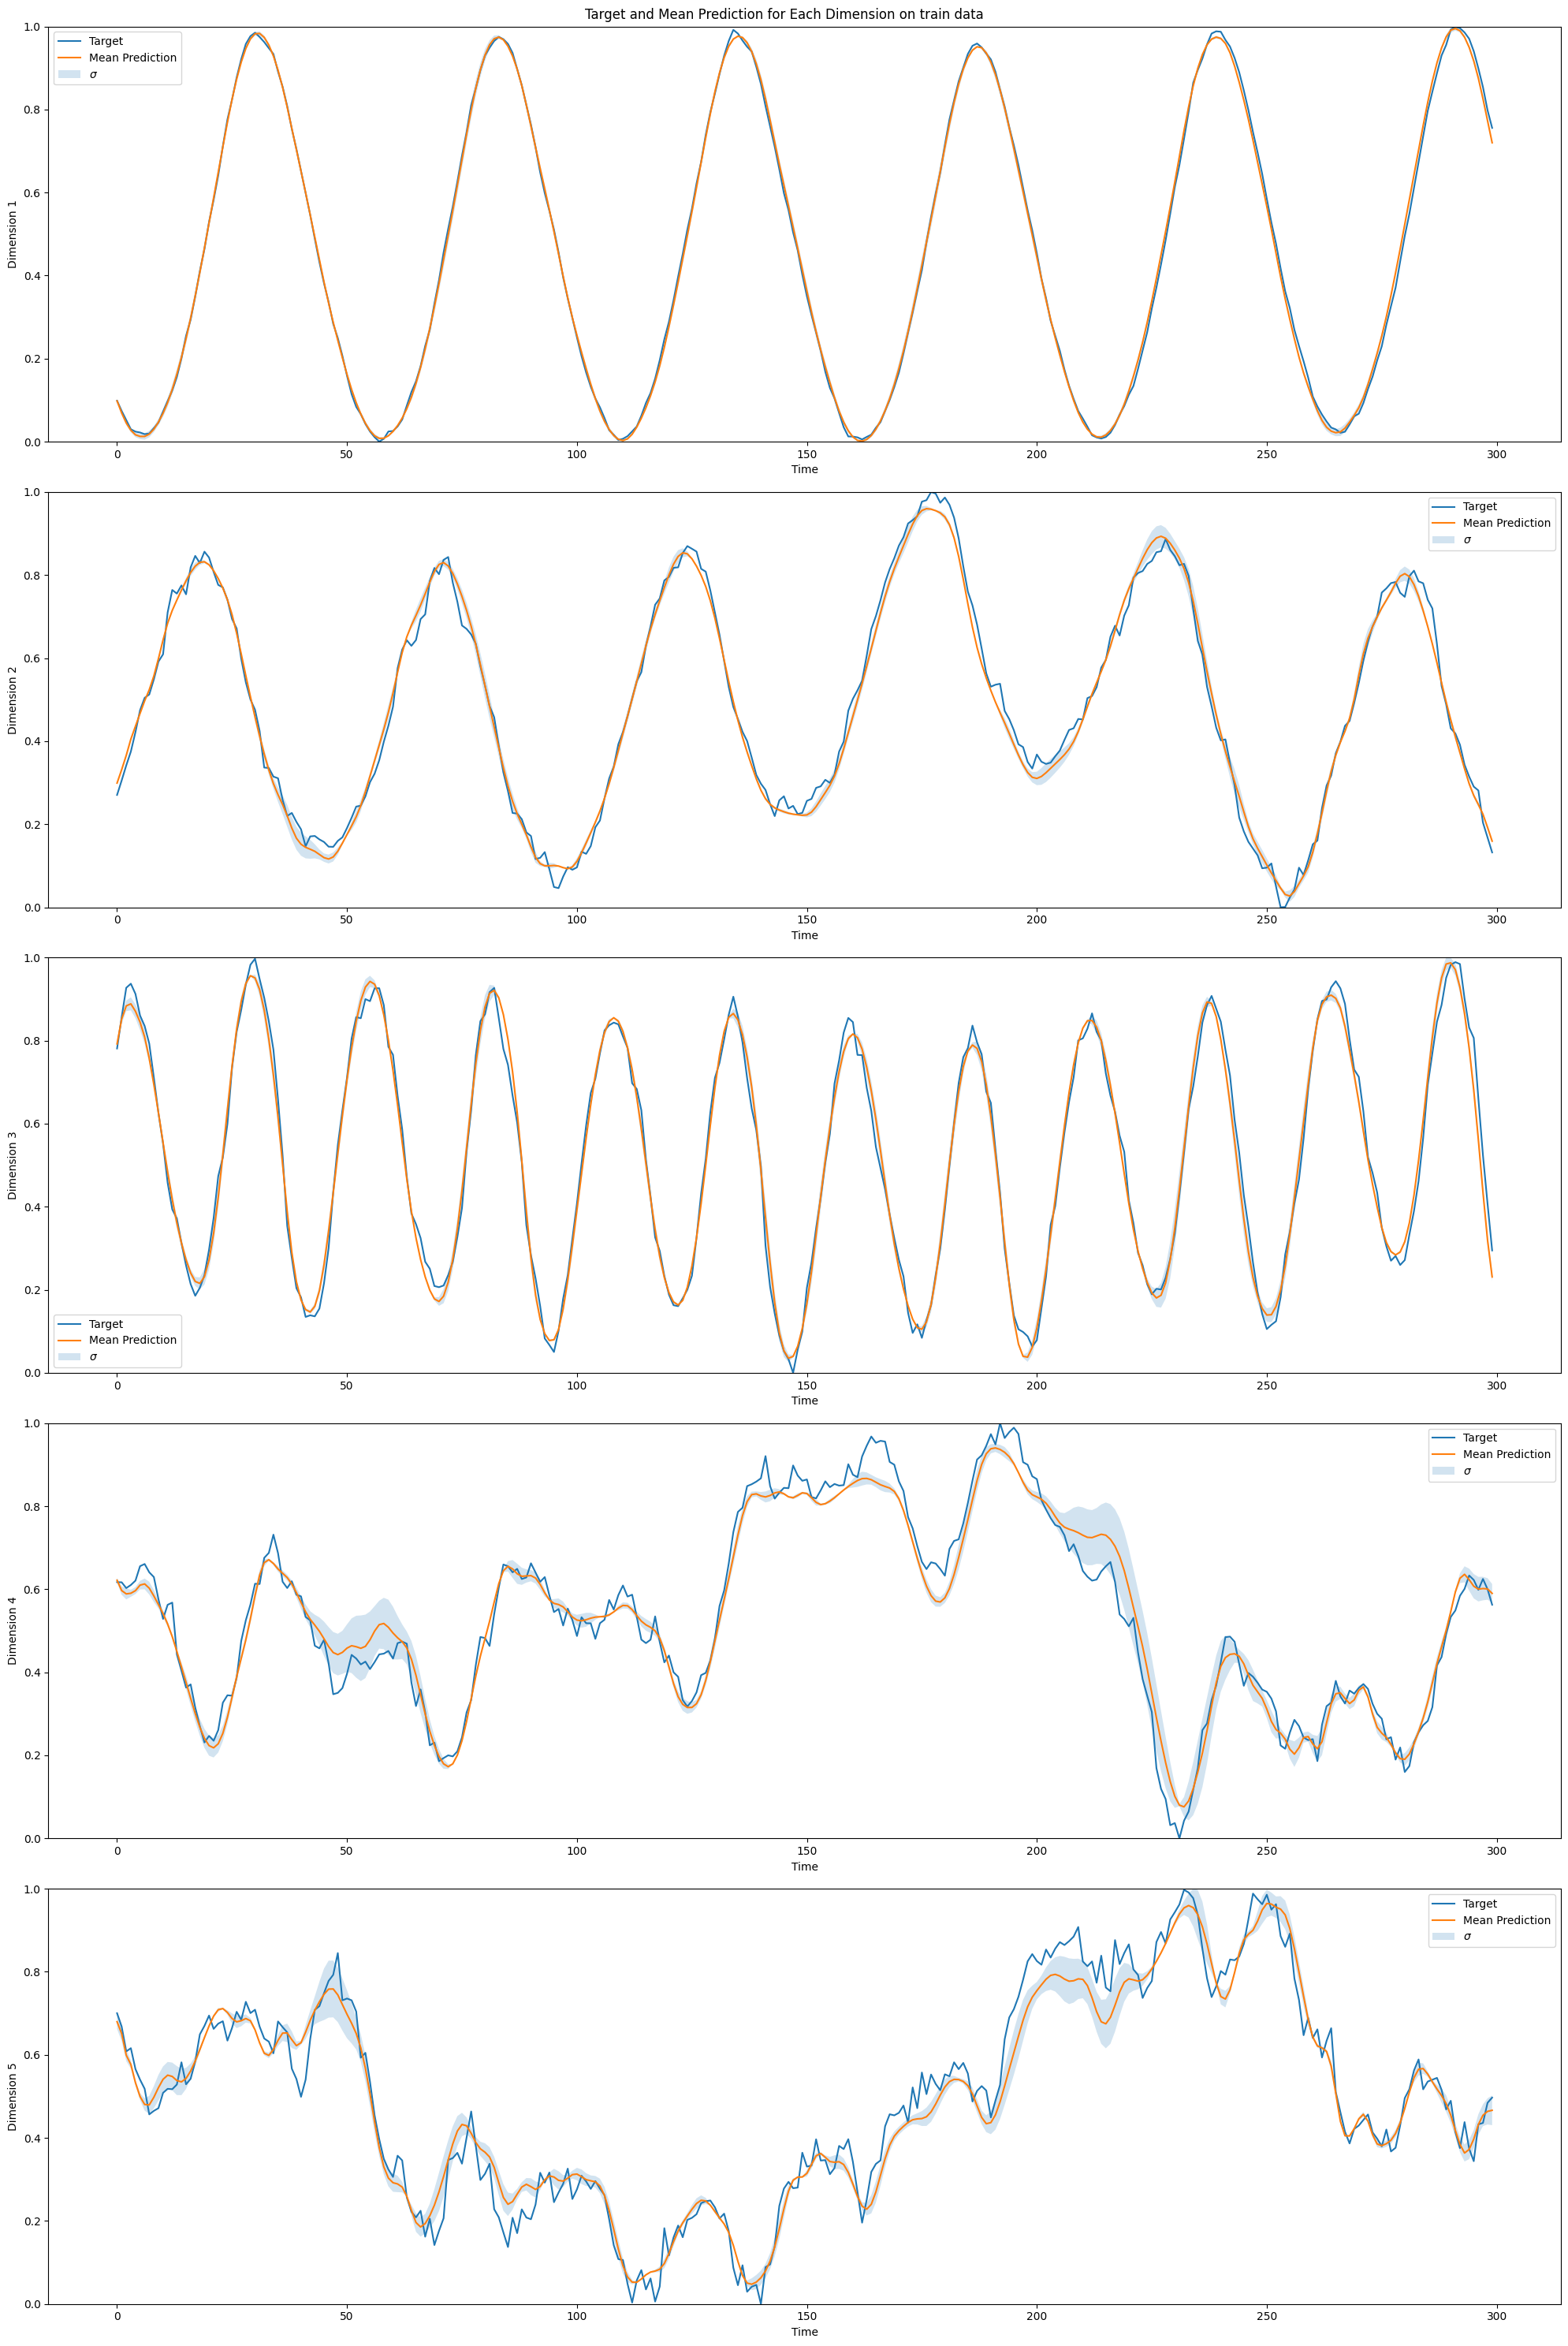

In [17]:
num_dimensions = mean_train_truths.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(20, 30))

# Iterate over each dimension
for dim in range(num_dimensions):
    # Extract arrays for the current dimension
    target_dim = mean_train_truths[:, dim]
    out_dim = mean_train_predictions[:, dim]
    std_dim = std_train_predictions[:, dim]

    # Calculate min and max values across all arrays for current dimension
    data_min = min(np.min(target_dim), np.min(out_dim - std_dim))
    data_max = max(np.max(target_dim), np.max(out_dim + std_dim))

    # Normalize arrays to [0, 1] range
    target_dim = (target_dim - data_min) / (data_max - data_min)
    out_dim = (out_dim - data_min) / (data_max - data_min)
    std_dim = std_dim / (data_max - data_min)  # std deviation is normalized accordingly

    # Plot target and output arrays
    axs[dim].plot(target_dim, label='Target')
    axs[dim].plot(out_dim, label='Mean Prediction')
    axs[dim].fill_between(range(len(out_dim)), out_dim - std_dim, out_dim + std_dim, alpha=0.2, label=r'$\sigma$')
    ####no std
    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)

    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim + 1}')
    axs[dim].legend()

# Add title
plt.suptitle('Target and Mean Prediction for Each Dimension on train data',y=0.99)
plt.subplots_adjust(hspace=0.5, top=0.85)
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()

In [18]:
predictions = []
truths = []
# temp = dict()
# temp[list(top_5_models_train.keys())[0]]=-1
for keys in top_5_models_train:
    predictions.append(outputs[keys])
    truths.append(targets[keys])
mean_test_predictions = np.mean(predictions, axis=0)
std_test_predictions = np.std(predictions, axis=0)
print("Mean predictions shape:", mean_test_predictions.shape)
print("Standard deviation shape:", std_test_predictions.shape)
print("Mean predictions:\n", mean_test_predictions)
print("Standard deviation:\n", std_test_predictions)
mean_test_truths = np.mean(truths, axis=0)
std_test_truths = np.std(truths, axis=0)
# print("Mean predictions shape:", mean_truths.shape)
# print("Standard deviation shape:", std_truths.shape)
# print("Mean predictions:\n", mean_truths)
# print("Standard deviation:\n", std_truths)

Mean predictions shape: (300, 5)
Standard deviation shape: (300, 5)
Mean predictions:
 [[424.97459796 -14.20355379  17.92490567 -64.99584032  51.425537  ]
 [381.05985648 -21.38348552  -8.26448818 -53.53037793  61.22395325]
 [351.48698419 -11.23288883 -22.05857997 -65.53869232  61.22395325]
 ...
 [ 56.80879259  82.13779569 -45.51607812 -86.13380318  40.85475842]
 [119.51149072  79.31896762 -31.07326874 -89.77082736  42.27761365]
 [182.87985344  75.50116021 -13.28535928 -90.33195092  43.00074267]]
Standard deviation:
 [[9.59928655e+00 6.80436641e+00 1.00129740e+01 2.62209797e-01
  1.76791304e+00]
 [1.06302947e+01 6.93607507e+00 1.32738792e+01 5.43139014e-02
  0.00000000e+00]
 [1.41952711e+01 5.92921245e+00 1.65776481e+01 4.09605676e+00
  0.00000000e+00]
 ...
 [1.20576595e+02 2.95992535e+00 1.91858279e+01 7.75504331e+00
  1.13365984e+01]
 [1.24657738e+02 4.87133124e+00 2.97628852e+01 1.25930684e+01
  1.15615860e+01]
 [1.26211485e+02 7.15259316e+00 3.88268934e+01 1.80809899e+01
  1.2222705

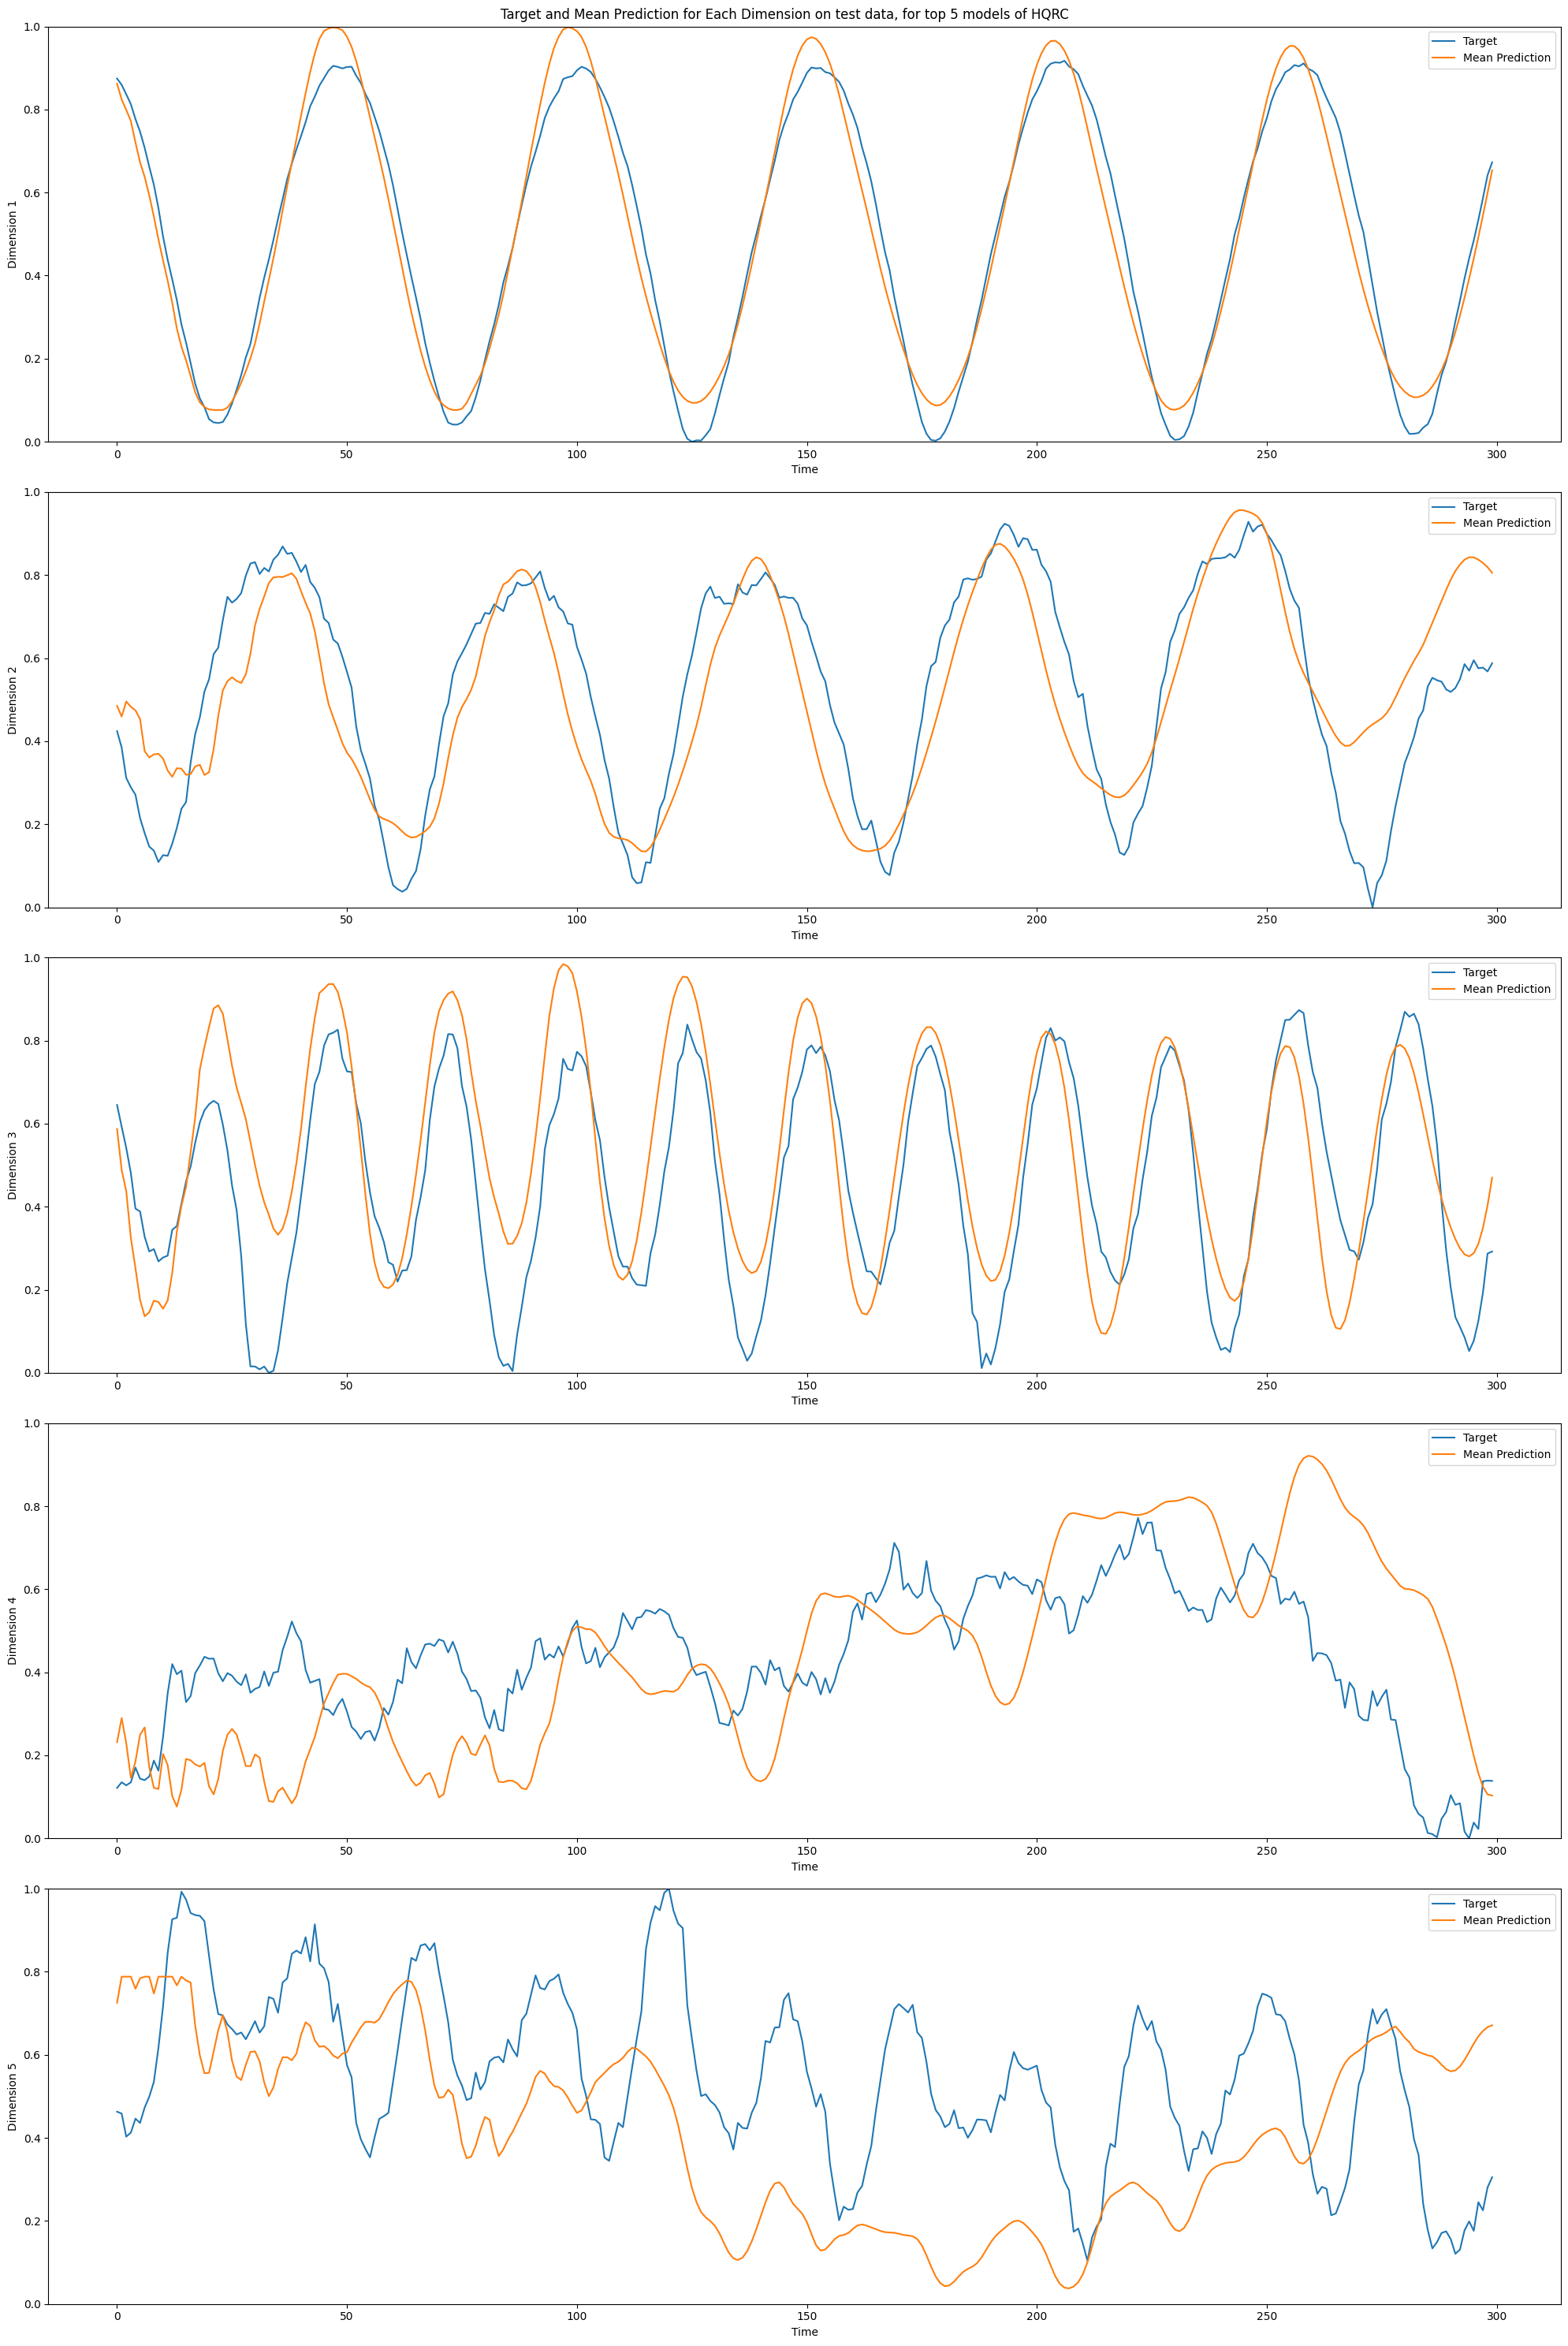

In [19]:
num_dimensions = mean_test_truths.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(20, 30))

# Iterate over each dimension
for dim in range(num_dimensions):
    # Extract arrays for the current dimension
    target_dim = mean_test_truths[:, dim]
    out_dim = mean_test_predictions[:, dim]
    std_dim = std_test_predictions[:, dim]

    # Calculate min and max values across all arrays for current dimension
    data_min = min(np.min(target_dim), np.min(out_dim - std_dim))
    data_max = max(np.max(target_dim), np.max(out_dim + std_dim))

    # Normalize arrays to [0, 1] range
    target_dim = (target_dim - data_min) / (data_max - data_min)
    out_dim = (out_dim - data_min) / (data_max - data_min)
    #std_dim = std_dim / (data_max - data_min)  # std deviation is normalized accordingly

    # Plot target and output arrays
    axs[dim].plot(target_dim, label='Target')
    axs[dim].plot(out_dim, label='Mean Prediction')
    #axs[dim].fill_between(range(len(out_dim)), out_dim - std_dim, out_dim + std_dim, alpha=0.2, label=r'$\sigma$')

    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)

    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim + 1}')
    axs[dim].legend()

# Add title
plt.suptitle('Target and Mean Prediction for Each Dimension on test data, for top 5 models of HQRC',y=0.99)
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()

## Reconstruction of Temperature map along and error analysis

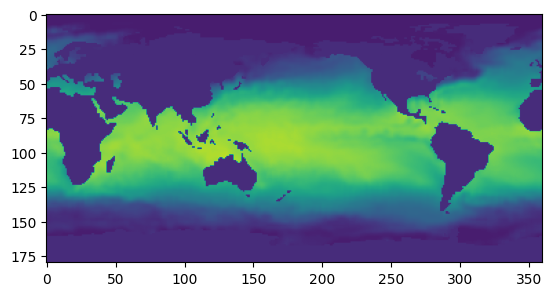

In [20]:
train_data = np.load('Data/sst_var_train',allow_pickle=True).data
test_data = np.load('Data/sst_var_test',allow_pickle=True).data
mask = np.load('Data/mask',allow_pickle=True)
#plt.imshow(train_data[0]*mask[0],vmin=-5,vmax=35)
plt.imshow(test_data[0]*mask[0],vmin=-5,vmax=35)

In [21]:
train_data_ml = train_data.reshape(427,180*360)
mask = mask[0].flatten()
mask = np.asarray(mask,dtype='bool')

train_data_ml = train_data_ml[:,mask]
train_data_ml.shape

# Find train data mean
train_data_mean = np.mean(train_data_ml,axis=0)
train_data_ml = train_data_ml - train_data_mean[None,]

In [22]:
test_data_ml = test_data.reshape(1487,180*360)
mask = np.load('Data/mask',allow_pickle=True)
mask = mask[0].flatten()
mask = np.asarray(mask,dtype='bool')

test_data_ml = test_data_ml[:,mask]
test_data_ml.shape

# Find train data mean
test_data_mean = np.mean(test_data_ml,axis=0)
test_data_ml = test_data_ml - test_data_mean[None,]

In [23]:
def field_compression(Y,K):
    '''
    Y - Snapshot matrix - shape: NxS
    K - number of modes to truncate to
    returns 
    V - truncated POD basis matrix - shape: NxK
    Ytilde - truncated coefficient matrix - shape: KxS
    '''
    V = generate_pod_bases(Y,K)
    Ytilde = field_coefficients(Y,V)

    return V, Ytilde

def generate_pod_bases(Y,K): #Mean removed
    '''
    Y - Snapshot matrix - shape: NxS
    returns V - truncated POD basis matrix - shape: NxK
    '''
    new_mat = np.matmul(np.transpose(Y),Y)
    w,v = np.linalg.eig(new_mat)

    # plt.figure()
    # plt.semilogy(w[:]/np.sum(w)*100)
    # plt.show()

    # Bases
    V = np.real(np.matmul(Y,v)) 
    trange = np.arange(np.shape(V)[1])
    V[:,trange] = V[:,trange]/np.sqrt(w[:])

    # Truncate phis
    V = V[:,0:K] # Columns are modes

    return V

def field_coefficients(Y,V):
    '''
    Y - Snapshot matrix - shape: NxS
    V - truncated POD basis matrix - shape: NxK
    returns Ytilde - shape: KxS
    '''
    return np.matmul(np.transpose(V),Y)

In [29]:
N_dim = 5

In [30]:
modes, coeffs = field_compression(train_data_ml.T,N_dim)
modes_test, coeffs_test = field_compression(test_data_ml.T,N_dim)

c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\hqr2-venv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


In [31]:
N_train=427
with open("./Data/testing_data_N{:d}_dim{:d}.pickle".format(N_train,N_dim), "rb") as file:
    data = pickle.load(file)
    data_test = data["test_input_sequence"]
    del data
with open("./Data/training_data_N{:d}_dim{:d}.pickle".format(N_train,N_dim), "rb") as file:
    data = pickle.load(file)
    data_train = data["train_input_sequence"]
    del data

In [32]:
np.allclose(data_train[116+300-1],targets_train[samples[0]][299])
#check

True

In [33]:
print(data_train[116+300-1])
print(mean_train_truths[299])
print(mean_train_predictions[299])
#check

[321.8648    -99.581604  -48.89029    -8.7071905  -2.9636319]
[321.86477661 -99.581604   -48.89028931  -8.70719147  -2.96363068]
[283.6409476  -92.39232977 -64.54903989  -3.44255869  -6.72125285]


In [34]:
test_ic = [116,40,66] #taken from randomly generated test indices from the data_analysis.ipynb file
pl_max = 300
dl_max = test_ic[0]
recon_data_ml = np.matmul(modes,data_train[test_ic[0]+pl_max-1].T).T
recon_data_ml = recon_data_ml + train_data_mean[None,]
recon_data = np.copy(train_data[test_ic[0]+pl_max-1])
recon_data = recon_data.reshape(1,180*360)
recon_data[0,mask] = recon_data_ml
recon_data = recon_data.reshape(1,180,360)

pred_data_ml = np.matmul(modes,mean_train_predictions.T).T
pred_data_ml = pred_data_ml + train_data_mean[None,]
pred_data = np.copy(train_data[test_ic[0]:test_ic[0]+pl_max])
pred_data = pred_data.reshape(pl_max,180*360)
pred_data[:,mask] = pred_data_ml
pred_data = pred_data.reshape(pl_max,180,360)
new_mask = np.load('Data/mask',allow_pickle=True)
#check if correctly done

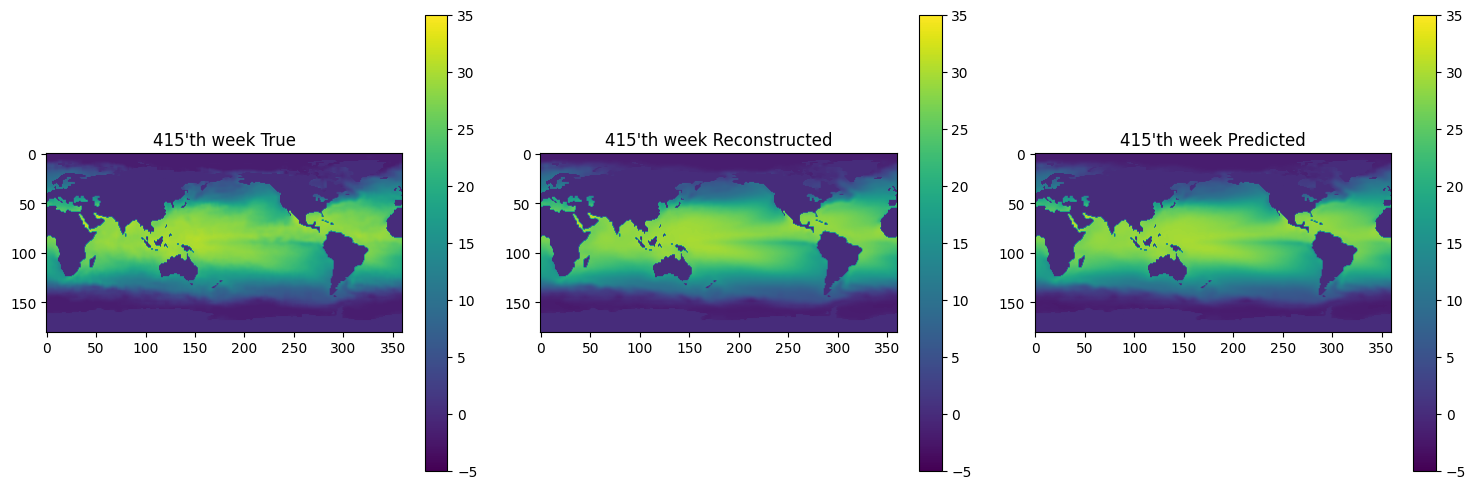

In [35]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
im1 = axs[0].imshow(train_data[dl_max+pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[0].set_title("{}'th week True".format(dl_max+pl_max-1))
fig.colorbar(im1, ax=axs[0], orientation='vertical')


# Plot the second subplot
im2 = axs[1].imshow(recon_data[0] * new_mask[0], vmin=-5, vmax=35)
axs[1].set_title("{}'th week Reconstructed".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Plot the third subplot
im3 = axs[2].imshow(pred_data[pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[2].set_title("{}'th week Predicted".format(dl_max+pl_max-1))
fig.colorbar(im3, ax=axs[2], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

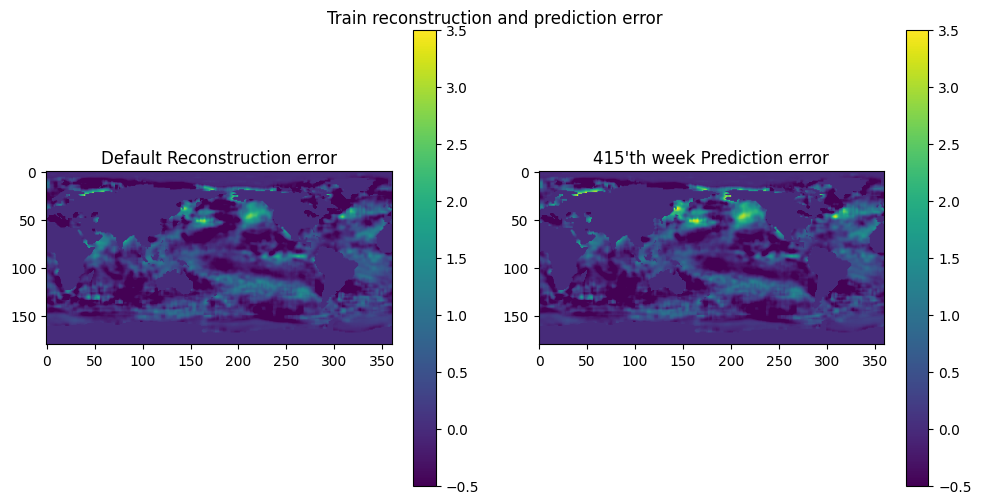

In [36]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
im1 = axs[0].imshow((train_data[dl_max+pl_max-1] - recon_data[0]) * new_mask[0], vmin=-0.5, vmax=3.5)
axs[0].set_title("Default Reconstruction error")
fig.colorbar(im1, ax=axs[0], orientation='vertical')

# Plot the second subplot
im2 = axs[1].imshow((train_data[dl_max+pl_max-1] - pred_data[pl_max-1]) * new_mask[0], vmin=-0.5, vmax=3.5)
axs[1].set_title("{}'th week Prediction error".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Adjust layout
plt.tight_layout()
plt.suptitle('Train reconstruction and prediction error',y=1)
# Show the figure
plt.show()

In [37]:
temp_true = train_data[dl_max:dl_max+pl_max]
rmse_pred = np.sqrt(np.mean((temp_true-pred_data)**2))
print(rmse_pred)

0.46460143


## For East Pacific Region

In [38]:
temp_true_ep = train_data[dl_max:dl_max+pl_max,80:100,200:250]
temp_pred_ep = pred_data[:,80:100,200:250]
rmse_pred = np.sqrt(np.mean((temp_true_ep-temp_pred_ep)**2))
print(rmse_pred)

0.53686076


## For test data

In [39]:
test_ic = [116,40,66] #taken from randomly generated test indices from the data_analysis.ipynb file
pl_max = 300
dl_max = test_ic[0]
recon_data_ml = np.matmul(modes_test,data_test[test_ic[0]+pl_max-1].T).T
recon_data_ml = recon_data_ml + test_data_mean[None,]
recon_data = np.copy(test_data[test_ic[0]+pl_max-1])
recon_data = recon_data.reshape(1,180*360)
recon_data[0,mask] = recon_data_ml
recon_data = recon_data.reshape(1,180,360)

pred_data_ml = np.matmul(modes_test,mean_test_predictions.T).T
pred_data_ml = pred_data_ml + test_data_mean[None,]
pred_data = np.copy(test_data[test_ic[0]:test_ic[0]+pl_max])
pred_data = pred_data.reshape(pl_max,180*360)
pred_data[:,mask] = pred_data_ml
pred_data = pred_data.reshape(pl_max,180,360)
new_mask = np.load('Data/mask',allow_pickle=True)
#check if correctly done

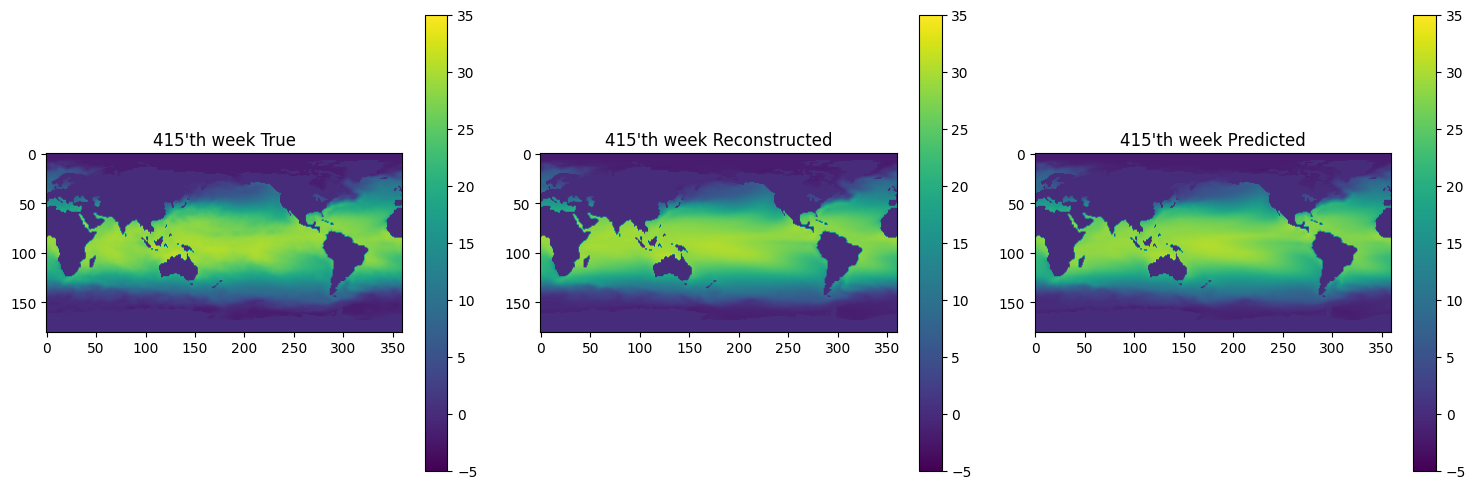

In [40]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
im1 = axs[0].imshow(test_data[dl_max+pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[0].set_title("{}'th week True".format(dl_max+pl_max-1))
fig.colorbar(im1, ax=axs[0], orientation='vertical')


# Plot the second subplot
im2 = axs[1].imshow(recon_data[0] * new_mask[0], vmin=-5, vmax=35)
axs[1].set_title("{}'th week Reconstructed".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Plot the third subplot
im3 = axs[2].imshow(pred_data[pl_max-1] * new_mask[0], vmin=-5, vmax=35)
axs[2].set_title("{}'th week Predicted".format(dl_max+pl_max-1))
fig.colorbar(im3, ax=axs[2], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

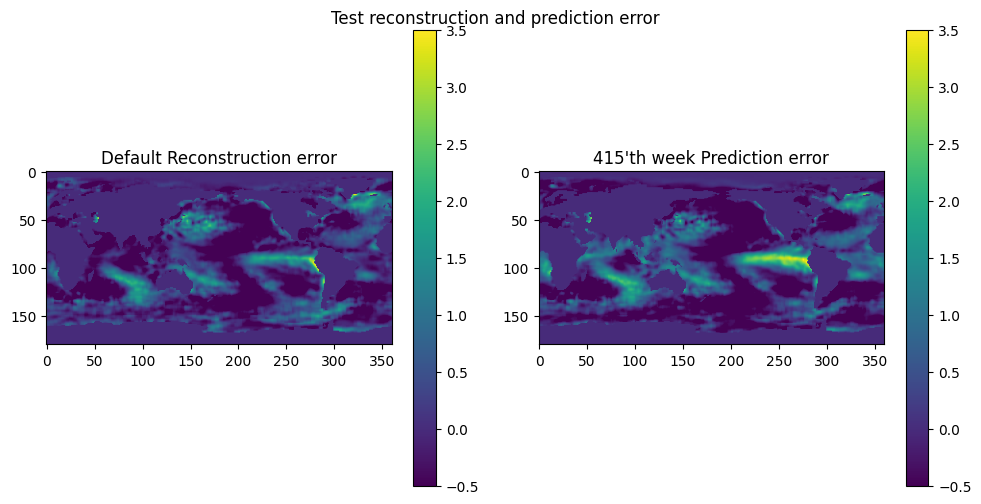

In [41]:
# Create a single figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot
im1 = axs[0].imshow((test_data[dl_max+pl_max-1] - recon_data[0]) * new_mask[0], vmin=-0.5, vmax=3.5)
axs[0].set_title("Default Reconstruction error")
fig.colorbar(im1, ax=axs[0], orientation='vertical')

# Plot the second subplot
im2 = axs[1].imshow((test_data[dl_max+pl_max-1] - pred_data[pl_max-1]) * new_mask[0], vmin=-0.5, vmax=3.5)
axs[1].set_title("{}'th week Prediction error".format(dl_max+pl_max-1))
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Adjust layout
plt.tight_layout()
plt.suptitle('Test reconstruction and prediction error',y=1)
# Show the figure
plt.show()

In [42]:
temp_true = test_data[dl_max:dl_max+pl_max]
rmse_pred = np.sqrt(np.mean((temp_true-pred_data)**2))
print(rmse_pred)

0.66970336


## For East Pacific Region

In [43]:
temp_true_ep = test_data[dl_max:dl_max+pl_max,80:100,200:250]
temp_pred_ep = pred_data[:,80:100,200:250]
rmse_pred = np.sqrt(np.mean((temp_true_ep-temp_pred_ep)**2))
print(rmse_pred)

1.0912033


## Memory and computation time analysis

In [44]:
models = []
samples = []
nqrc = [20, 10,5]
coupling = [0.5,1.0,2.0,4.0]
tau = [1.0,2.0,4.0,8.0]
for J in coupling:
    for t in tau:
        for n_qrc in nqrc:
            string1 = f"hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_{n_qrc}-A_0.5-J_{J}-fJ_1-V_10-TAU_{t}-UNIT_6-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_3"
            string2 = f"HQRC-NQRC={n_qrc}-J={J}-tau={t}"
            models.append([os.path.join(model_path,string1),string2])
            samples.append(string2)
title = "Sea Surface Temperatures"

In [45]:
train_time_dict = dict()
memory_dict = dict()
trainable_parameters_dict = dict()
for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'data.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            train_time_dict[label]=rs["total_training_time"]
            trainable_parameters_dict[label]=rs["n_trainable_parameters"]
            memory_dict[label]=rs["memory"]
    else:
        print('Not found {}'.format(fname))

In [46]:
train_time_dict

{'HQRC-NQRC=20-J=0.5-tau=1.0': 71.80277466773987,
 'HQRC-NQRC=10-J=0.5-tau=1.0': 42.4073646068573,
 'HQRC-NQRC=5-J=0.5-tau=1.0': 13.601481676101685,
 'HQRC-NQRC=20-J=0.5-tau=2.0': 88.00681471824646,
 'HQRC-NQRC=10-J=0.5-tau=2.0': 37.029107093811035,
 'HQRC-NQRC=5-J=0.5-tau=2.0': 18.05183243751526,
 'HQRC-NQRC=20-J=0.5-tau=4.0': 81.60812473297119,
 'HQRC-NQRC=10-J=0.5-tau=4.0': 35.972190856933594,
 'HQRC-NQRC=5-J=0.5-tau=4.0': 16.500946760177612,
 'HQRC-NQRC=20-J=0.5-tau=8.0': 77.8572313785553,
 'HQRC-NQRC=10-J=0.5-tau=8.0': 36.73859119415283,
 'HQRC-NQRC=5-J=0.5-tau=8.0': 16.339390754699707,
 'HQRC-NQRC=20-J=1.0-tau=1.0': 74.05039405822754,
 'HQRC-NQRC=10-J=1.0-tau=1.0': 34.785484313964844,
 'HQRC-NQRC=5-J=1.0-tau=1.0': 16.548083782196045,
 'HQRC-NQRC=20-J=1.0-tau=2.0': 74.78977823257446,
 'HQRC-NQRC=10-J=1.0-tau=2.0': 34.475244760513306,
 'HQRC-NQRC=5-J=1.0-tau=2.0': 16.378591775894165,
 'HQRC-NQRC=20-J=1.0-tau=4.0': 78.27825474739075,
 'HQRC-NQRC=10-J=1.0-tau=4.0': 36.85501289367676,

In [47]:
memory_dict

{'HQRC-NQRC=20-J=0.5-tau=1.0': 144.625,
 'HQRC-NQRC=10-J=0.5-tau=1.0': 115.08984375,
 'HQRC-NQRC=5-J=0.5-tau=1.0': 105.58984375,
 'HQRC-NQRC=20-J=0.5-tau=2.0': 144.97265625,
 'HQRC-NQRC=10-J=0.5-tau=2.0': 115.22265625,
 'HQRC-NQRC=5-J=0.5-tau=2.0': 105.71484375,
 'HQRC-NQRC=20-J=0.5-tau=4.0': 145.1875,
 'HQRC-NQRC=10-J=0.5-tau=4.0': 115.9375,
 'HQRC-NQRC=5-J=0.5-tau=4.0': 105.52734375,
 'HQRC-NQRC=20-J=0.5-tau=8.0': 145.765625,
 'HQRC-NQRC=10-J=0.5-tau=8.0': 115.5625,
 'HQRC-NQRC=5-J=0.5-tau=8.0': 105.609375,
 'HQRC-NQRC=20-J=1.0-tau=1.0': 144.9296875,
 'HQRC-NQRC=10-J=1.0-tau=1.0': 116.1171875,
 'HQRC-NQRC=5-J=1.0-tau=1.0': 105.8125,
 'HQRC-NQRC=20-J=1.0-tau=2.0': 145.5546875,
 'HQRC-NQRC=10-J=1.0-tau=2.0': 115.42578125,
 'HQRC-NQRC=5-J=1.0-tau=2.0': 105.75390625,
 'HQRC-NQRC=20-J=1.0-tau=4.0': 145.0546875,
 'HQRC-NQRC=10-J=1.0-tau=4.0': 115.4140625,
 'HQRC-NQRC=5-J=1.0-tau=4.0': 105.45703125,
 'HQRC-NQRC=20-J=1.0-tau=8.0': 145.09765625,
 'HQRC-NQRC=10-J=1.0-tau=8.0': 115.48046875,
 '

In [48]:
trainable_parameters_dict

{'HQRC-NQRC=20-J=0.5-tau=1.0': 6005,
 'HQRC-NQRC=10-J=0.5-tau=1.0': 3005,
 'HQRC-NQRC=5-J=0.5-tau=1.0': 1505,
 'HQRC-NQRC=20-J=0.5-tau=2.0': 6005,
 'HQRC-NQRC=10-J=0.5-tau=2.0': 3005,
 'HQRC-NQRC=5-J=0.5-tau=2.0': 1505,
 'HQRC-NQRC=20-J=0.5-tau=4.0': 6005,
 'HQRC-NQRC=10-J=0.5-tau=4.0': 3005,
 'HQRC-NQRC=5-J=0.5-tau=4.0': 1505,
 'HQRC-NQRC=20-J=0.5-tau=8.0': 6005,
 'HQRC-NQRC=10-J=0.5-tau=8.0': 3005,
 'HQRC-NQRC=5-J=0.5-tau=8.0': 1505,
 'HQRC-NQRC=20-J=1.0-tau=1.0': 6005,
 'HQRC-NQRC=10-J=1.0-tau=1.0': 3005,
 'HQRC-NQRC=5-J=1.0-tau=1.0': 1505,
 'HQRC-NQRC=20-J=1.0-tau=2.0': 6005,
 'HQRC-NQRC=10-J=1.0-tau=2.0': 3005,
 'HQRC-NQRC=5-J=1.0-tau=2.0': 1505,
 'HQRC-NQRC=20-J=1.0-tau=4.0': 6005,
 'HQRC-NQRC=10-J=1.0-tau=4.0': 3005,
 'HQRC-NQRC=5-J=1.0-tau=4.0': 1505,
 'HQRC-NQRC=20-J=1.0-tau=8.0': 6005,
 'HQRC-NQRC=10-J=1.0-tau=8.0': 3005,
 'HQRC-NQRC=5-J=1.0-tau=8.0': 1505,
 'HQRC-NQRC=20-J=2.0-tau=1.0': 6005,
 'HQRC-NQRC=10-J=2.0-tau=1.0': 3005,
 'HQRC-NQRC=5-J=2.0-tau=1.0': 1505,
 'HQRC-NQR